In [110]:
%reload_ext autoreload
%autoreload 2

In [111]:
import pandas as pd
import numpy as np
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

%matplotlib inline
sns.set()

In [112]:
df = pd.read_csv('nbc_analysis.log', sep='|', header=0, names=['log_ts','level','module','msg'])
RAW = df

In [113]:
df.module.value_counts()

nbc_analysis.generate_po1_profiles.main            11769
nbc_analysis.partition.partition_by_viewer.main     7693
nbc_analysis.utils.aws_utils                         961
nbc_analysis.batch.extract_events.main               838
nbc_analysis.batch.upload_batches.main               838
nbc_analysis.utils.io_utils.aws_io                   814
nbc_analysis.utils.io_utils.csv_io                    89
nbc_analysis.runs.run_batches                         52
nbc_analysis.batch.size_batches.main                  38
nbc_analysis.batch.extract_file_lists.main            26
nbc_analysis.utils.config_utils                       13
nbc_analysis.runs.init_run.main                        6
Name: module, dtype: int64

In [114]:
start_week_mask = df.msg.str.startswith('start week')
end_week_mask = df.msg.str.startswith('end week')
write_partition_mask = (df.module == 'nbc_analysis.batch.extract_events.main') & (df.msg.str.startswith('wrote partition'))

In [115]:
df[write_partition_mask]

,log_ts,level,module,msg
36,"2019-10-11 19:15:00,354",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
38,"2019-10-11 19:15:58,513",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
40,"2019-10-11 19:16:54,131",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
42,"2019-10-11 19:17:51,622",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
44,"2019-10-11 19:19:15,830",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
...,...,...,...,...
2619,"2019-10-12 16:35:10,042",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
2621,"2019-10-12 16:36:46,431",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
2623,"2019-10-12 16:38:14,892",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
2625,"2019-10-12 16:39:39,742",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...


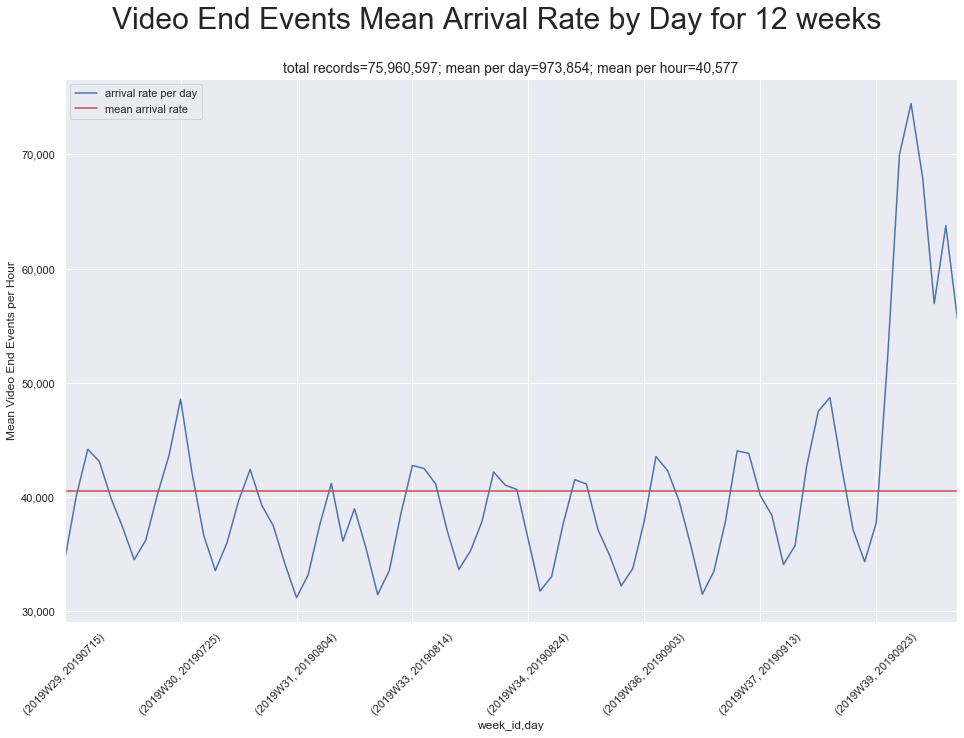

In [116]:
df = RAW[write_partition_mask].copy()
items = df.msg.str.split(',')
record_cnt = pd.Series(items.map(lambda x: x[1].split('=')[1]), name='record_cnt').astype(np.int)
batch_id = pd.Series(items.map(lambda x: x[0].split('/')[-1].split('.')[0]), name='batch_id')
day = pd.Series(batch_id.map(lambda x: x.split('_')[1]), name='day')
day_seq = pd.Series(batch_id.map(lambda x: x.split('_')[2]), name='day_seq')
week_id = pd.Series(items.map( lambda x: x[0].split('/')[7]), name= 'week_id')

df = pd.DataFrame([week_id, day, batch_id, record_cnt]).T
df['records_per_day'] = 24
df = df.sort_values('day')
record_cnt = df.groupby(['week_id', 'day']).record_cnt.sum()[:-1]
records_per_day = record_cnt.mean().round()

total_records = record_cnt.sum()

subtitle2 = "mean per day={:,.0f}".format(records_per_day)
subtitle3 = "mean per hour={:,.0f}".format(records_per_day/ 24)
subtitle1 = "total records={:,.0f}".format(total_records)

fig = plt.figure(figsize=[16, 10])
fig.suptitle(f'Video End Events Mean Arrival Rate by Day for 12 weeks', fontsize=30)

ax = record_cnt.div(24).plot(rot=45, label='arrival rate per day')
ax.set_title(f'{subtitle1}; {subtitle2}; {subtitle3}', fontsize=14);
ax.set_ylabel('Mean Video End Events per Hour')
ax.set_yticklabels(['{:,d}'.format(int(y)) for y in ax.get_yticks()]);
ax.axhline(y= records_per_day/24, color='r', label='mean arrival rate')
ax.legend();

In [117]:
event_type = pd.read_csv(StringIO("""event_type;sample_cnt
custom_event;240261 
user_attribute_change;82989 
application_state_transition;28167 
session_start;6917 
session_end;6285 
push_message;3969 
push_registration;692 
user_identity_change;73 
:none;4 
"""), sep=';')
event_type['event_type_pct'] = event_type.sample_cnt / event_type.sample_cnt.sum()
event_type

,event_type,sample_cnt,event_type_pct
0,custom_event,240261,0.650484
1,user_attribute_change,82989,0.224685
2,application_state_transition,28167,0.076260
3,session_start,6917,0.018727
4,session_end,6285,0.017016
5,push_message,3969,0.010746
6,push_registration,692,0.001874
7,user_identity_change,73,0.000198
8,:none,4,0.000011


In [118]:
event_name = pd.read_csv(StringIO("""event_name;sample_cnt
Ad End;15165 
Ad Start;15016 
Page Load;8652 
Ad Pod Start;3804 
Ad Pod End;3525 
Video Preview;3010 
Content Click;2547 
Launch;1620 
Video Start;1539 
Video End;1473 
End Card;528 
Error;372 
Click Action;252 
Linear Program End;207 
Linear End;200 
Linear Program Start;176 
Linear Start;168 
Search Result;138 
Authentication Success;53
MVPD Page Abandoned;42 
Conversion;25 
NBC Authentication Success;24 
Error CPC;11 
Registration Success;9 
Error IDM;3 
NBC Sign Out;3 
Item Favorited;2"""), sep=';')
event_name['event_type'] = 'custom_event'
event_name['event_pct'] = event_name.sample_cnt / event_name.sample_cnt.sum()
event_name

,event_name,sample_cnt,event_type,event_pct
0,Ad End,15165,custom_event,0.258947
1,Ad Start,15016,custom_event,0.256403
2,Page Load,8652,custom_event,0.147736
3,Ad Pod Start,3804,custom_event,0.064955
4,Ad Pod End,3525,custom_event,0.060191
5,Video Preview,3010,custom_event,0.051397
6,Content Click,2547,custom_event,0.043491
7,Launch,1620,custom_event,0.027662
8,Video Start,1539,custom_event,0.026279
9,Video End,1473,custom_event,0.025152


In [119]:
ve_ratio = event_name[event_name.event_name == 'Video End'].iloc[0].event_pct
cust_events_per_day = records_per_day/ ve_ratio
cust_events_per_day
event_name['est_events_per_day'] = (event_name.event_pct * cust_events_per_day).round().astype(np.int)

print(event_name.est_events_per_day.sum())
#event_name

38718794


In [120]:
total_custom_events = event_name.est_events_per_day.sum()
total_custom_events

38718794

In [121]:
custom_event_ratio = event_type.query('event_type=="custom_event"').event_type_pct[0]
total_event_types = total_custom_events / custom_event_ratio
total_event_types

59523008.709103845

In [122]:
event_type['est_events_per_day'] = (event_type.event_type_pct * total_event_types).round().astype(np.int)
event_type['event_name'] = event_type.event_type
#event_type

In [197]:
cols = ['event_type', 'event_name', 'est_events_per_day']

estimates = pd.concat( [event_type.iloc[1:][cols],event_name[cols]]).sort_values(['est_events_per_day'], ascending=False)
estimates['est_events_per_hour'] = (estimates.est_events_per_day / 24).round(1)
estimates['est_events_per_sec'] =estimates['est_events_per_sec'] = (estimates['est_events_per_hour'] / (60*60)).round(1)
estimates['in_scope'] = estimates.event_name.isin({'Video End','Video Start', 'End Card','Ad End', 'Ad Start'})
estimates  = estimates.reset_index(drop=True)
estimates.index.name = 'idx'
estimates[estimates.in_scope]

,event_type,event_name,est_events_per_day,est_events_per_hour,est_events_per_sec,in_scope
idx,,,,,,
1,custom_event,Ad End,10026134,417755.6,116.0,True
2,custom_event,Ad Start,9927625,413651.0,114.9,True
11,custom_event,Video Start,1017489,42395.4,11.8,True
13,custom_event,Video End,973854,40577.2,11.3,True
15,custom_event,End Card,349080,14545.0,4.0,True


In [204]:
df = pd.DataFrame({
'stress_test'  :estimates.event_name.isin({'Video End'}),
'stress_test_agg'  :estimates.event_name.isin({'Video End', 'End Card'}),
'release_1031' : estimates.event_name.isin({'Video Start'}),
'release_1031_agg' : estimates.event_name.isin({'Video Start', 'End Card'}),
'by_time_period' : estimates.event_name.isin({'Video Start'}),
'by_time_period_agg': estimates.event_name.isin({'Video Start','Video End', 'End Card'}),
'ad_tolerance':estimates.event_name.isin({'Video Start'}),
'ad_tolerance_agg':estimates.event_name.isin({'Video Start', 'Video End', 'Ad Start', 'Ad End', 'End Card'}),
})
df.columns.name = 'release_id'
df = df.stack().to_frame('in_release')
df = df.reset_index('release_id')

release_est = estimates.join(df)
release_est = release_est[release_est.in_release]

In [212]:
attr_per_release = [{'release_id': 'stress_test', 'release': 'Stress Test', 'po1_expansion': 2.,'aggregation': 'Post Aggregation'},
                    {'release_id': 'stress_test_agg', 'release': 'Stress Test', 'po1_expansion': 2.,'aggregation': 'Pre Aggregation'},
                    {'release_id': 'release_1031','release': 'Oct 31 Release', 'po1_expansion': 5, 'aggregation': 'Post Aggregation'},
                    {'release_id': 'release_1031_agg','release': 'Oct 31 Release', 'po1_expansion': 5, 'aggregation': 'Pre Aggregation'},
                    {'release_id': 'by_time_period', 'release': 'By Time Period', 'po1_expansion': 7, 'aggregation': 'Post Aggregation' },
                    {'release_id': 'by_time_period_agg', 'release': 'By Time Period',  'po1_expansion': 7, 'aggregation': 'Pre Aggregation'},
                    {'release_id': 'ad_tolerance', 'release': 'Ad Tolerance', 'po1_expansion': 12, 'aggregation': 'Post Aggregation'},
                    {'release_id': 'ad_tolerance_agg', 'release': 'Ad Tolerance', 'po1_expansion': 12,'aggregation': 'Pre Aggregation'}]

df = pd.DataFrame.from_records(attr_per_release)
df = df.merge(release_est, on='release_id')
df = df[df.in_release]
df['est_po1_events_per_sec'] = df['po1_expansion'] * df['est_events_per_sec']
DATA = df
DATA[DATA.release == 'Ad Tolerance']

,release_id,release,po1_expansion,aggregation,event_type,event_name,est_events_per_day,est_events_per_hour,est_events_per_sec,in_scope,in_release,est_po1_events_per_sec
10,ad_tolerance,Ad Tolerance,12.0,Post Aggregation,custom_event,Video Start,1017489,42395.4,11.8,True,True,141.6
11,ad_tolerance_agg,Ad Tolerance,12.0,Pre Aggregation,custom_event,Ad End,10026134,417755.6,116.0,True,True,1392.0
12,ad_tolerance_agg,Ad Tolerance,12.0,Pre Aggregation,custom_event,Ad Start,9927625,413651.0,114.9,True,True,1378.8
13,ad_tolerance_agg,Ad Tolerance,12.0,Pre Aggregation,custom_event,Video Start,1017489,42395.4,11.8,True,True,141.6
14,ad_tolerance_agg,Ad Tolerance,12.0,Pre Aggregation,custom_event,Video End,973854,40577.2,11.3,True,True,135.6
15,ad_tolerance_agg,Ad Tolerance,12.0,Pre Aggregation,custom_event,End Card,349080,14545.0,4.0,True,True,48.0


In [232]:
df = DATA.copy()
df = df[df.release_id == 'stress_test']

## Calcuate events per day
events_per_sec =df.est_po1_events_per_sec.sum()
days_in_hist = 8 * 7 
secs_in_day = (24 * 60*60)
events_per_day = events_per_sec * secs_in_day
events_in_hist = events_per_day * days_in_hist

print("events_per_sec:", events_per_sec)
print("events_per_day:", events_per_day)
print("events_per_hour:", events_per_day/24)
print("events_in_history:", events_in_hist)
rate_per_sec = 700
rate_per_day = rate_per_sec * 60 * 60 * 24
days_to_reload = events_in_hist / rate_per_day
print('days_to_reload:', days_to_reload)

events_per_sec: 22.6
events_per_day: 1952640.0000000002
events_per_hour: 81360.00000000001
events_in_history: 109347840.00000001
days_to_reload: 1.8080000000000003


In [233]:
14979686400.0/ 109347840

136.99115044247787

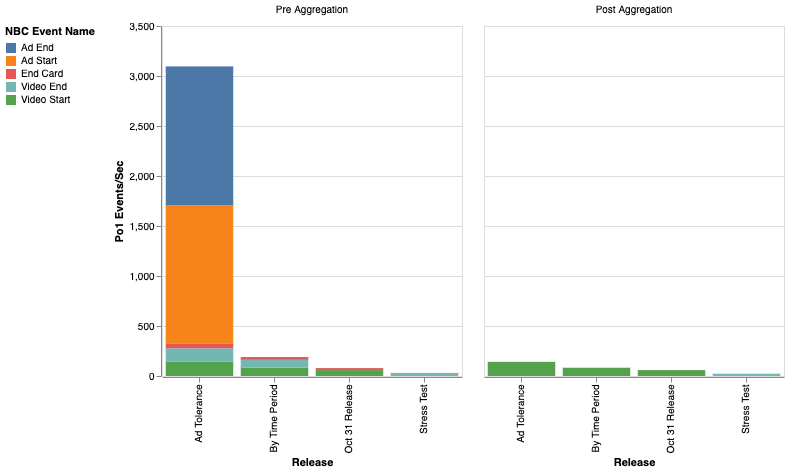

In [211]:
RAW = DATA.rename(columns={
    'est_events_per_sec': 'NBC Events/Sec',
    'est_po1_events_per_sec': 'Po1 Events/Sec',
    'release': 'Release',
    'event_name': 'NBC Event Name'})
RAW['Tested Throughput'] = 700

event_cat, y_height = 'Po1 Events/Sec', 3500
#event_cat, y_height = 'NBC Events/Sec', 300
chart_one = alt.Chart(RAW).mark_bar().encode(
    column=alt.Color('aggregation', title=None, sort=["Pre Aggregation", "Post Aggregation"]),  # The order to sort in
    y=alt.Y(event_cat, scale=alt.Scale(domain=(0,y_height))),
    x=alt.X('Release'),
    color=alt.Color('NBC Event Name', legend=alt.Legend(orient='left'))
).properties(width=300, height=350)

chart_one

In [187]:
def adda_total(col):
    dx = df.groupby(['event_name','release',])[col].sum().unstack()
    #ds = dx.sum(axis=0)
    #ds.name = 'TOTAL'
    #dx = dx.append(ds )
    #dx = dx.fillna('')
    display(dx)

#show_est('est_events_per_sec')
#show_est('est_po1_events_per_sec')

In [109]:
#collapse events
mask = estimates.est_events_per_sec < 1
dx = estimates[mask]

x = dx.iloc[0].copy()

cols = ['est_events_per_day','est_events_per_hour','est_events_per_sec']
x[cols] = dx[cols].sum()
x['event_name'] = 'ALL OTHER EVENTS'
estimates = estimates[~mask].append(x)
estimates = estimates[estimates['colors'] == 'r']
estimates

KeyError: 'colors'

In [108]:
estimates[estates.stress_test]

NameError: name 'estates' is not defined

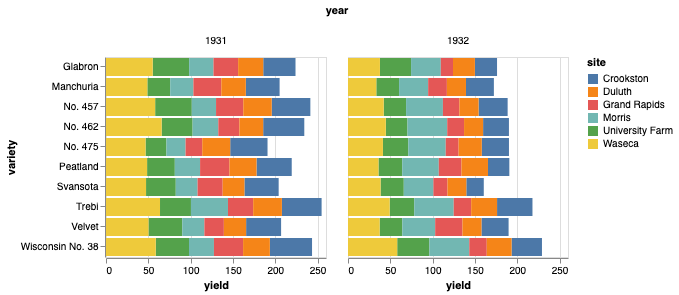

In [155]:




alt.Chart(source).mark_bar().encode(
    column='year',
    x='yield',
    y='variety',
    color='site'
).properties(width=220)

In [156]:
import altair as alt
from vega_datasets import data

source = data.barley()
source.head()

,yield,variety,year,site
0,27.00000,Manchuria,1931,University Farm
1,48.86667,Manchuria,1931,Waseca
2,27.43334,Manchuria,1931,Morris
3,39.93333,Manchuria,1931,Crookston
4,32.96667,Manchuria,1931,Grand Rapids


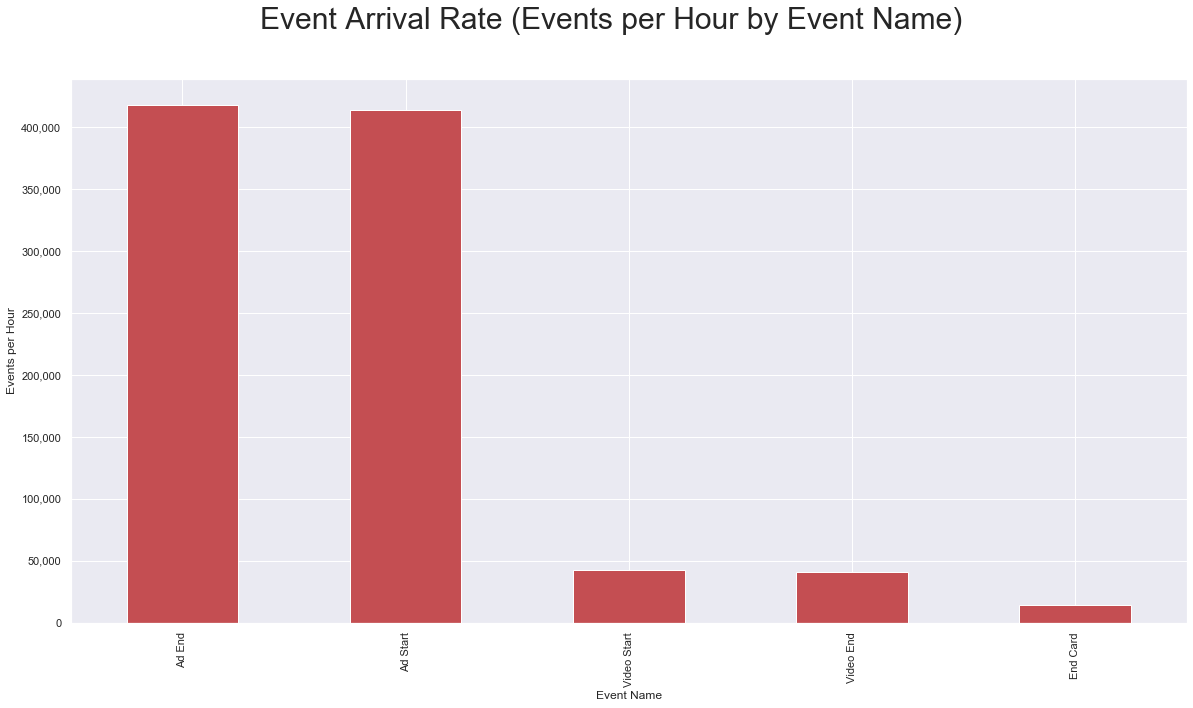

In [55]:
fig = plt.figure(figsize=(20,10))
fig.suptitle("Event Arrival Rate (Events per Hour by Event Name)", fontsize=30)

per_hour = estimates.set_index('event_name').est_events_per_hour
ax = per_hour.plot(kind='bar', color=estimates.colors)
ax.set_xlabel('Event Name')
ax.set_ylabel('Events per Hour')
ax.set_yticklabels(['{:,d}'.format(int(y)) for y in ax.get_yticks()]);
print()

In [128]:
dx = estimates[estimates.in_scope][['event_name','est_events_per_day','est_events_per_hour']].set_index('event_name')
total = pd.Series(dx.sum(),name='TOTAL')
dx = dx.append(total)

ds = ((dx / total).round(3)*100)['est_events_per_hour']
dx = dx.applymap("{:,.0f}".format)
ds.name = 'Pct'
dx['pct'] = ds.map("{:,}%".format)
dx.columns = ['Events/Day', 'Events/Hour', 'Pct']
dx.index.name = 'Event Name'
print("\n")
dx

,Events/Day,Events/Hour,Pct
Event Name,,,
End Card,"349,080","14,545",3.1%
Video End,"973,854","40,577",8.6%
Ad End,"10,026,134","417,756",88.3%
TOTAL,"11,349,068","472,878",100.0%


In [197]:
df = pd.read_csv(StringIO("""measure;rate
observed arrival rate - end car;15000
observed arrival rate - video end;50000
observed arrival rate - in scope events;500000
phase 1 target;600000
optimization work - s3 to memory (1cpu),;230219280
optimization work - vectorized calculations (1cpu);46043856000000
"""),sep=';')
rates = df.set_index('measure')
rates

,rate
measure,
observed arrival rate - end car,15000
observed arrival rate - video end,50000
observed arrival rate - in scope events,500000
phase 1 target,600000
"optimization work - s3 to memory (1cpu),",230219280
optimization work - vectorized calculations (1cpu),46043856000000


In [224]:
df = pd.Series(range(13))
df =(df * (7* 24 * 500000)).to_frame()[1:]
df.index.name = 'weeks_of_history'
df.columns = ['events_in_history']
weeks = df
print( "# Events history (in M) assuming arrival rate of 500K")
weeks.T/ 10**6

# Events history (in M) assuming arrival rate of 500K


weeks_of_history,1,2,3,4,5,6,7,8,9,10,11,12
events_in_history,84.0,168.0,252.0,336.0,420.0,504.0,588.0,672.0,756.0,840.0,924.0,1008.0


In [225]:
print("Days to load N weeks history, assuming arrival rate of 500K")
load_times  =pd.DataFrame(np.outer((1/rates),weeks), columns=weeks.index, index=rates.index).div(24).round(2)[3:]
load_times

Days to load N weeks history, assuming arrival rate of 500K


weeks_of_history,1,2,3,4,5,6,7,8,9,10,11,12
measure,,,,,,,,,,,,
phase 1 target,5.83,11.67,17.50,23.33,29.17,35.00,40.83,46.67,52.50,58.33,64.17,70.00
"optimization work - s3 to memory (1cpu),",0.02,0.03,0.05,0.06,0.08,0.09,0.11,0.12,0.14,0.15,0.17,0.18
optimization work - vectorized calculations (1cpu),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
